# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
info = pd.read_excel('data/DIAS_Attributes_Values_2017.xlsx',header =1, usecols =['Attribute','Description','Value','Meaning'])

In [4]:
azdias.shape

(891221, 366)

In [5]:
customers.shape

(191652, 369)

In [6]:
azdias.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1


In [7]:
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4


In [8]:
azdias.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   LNR                          891221 non-null  int64  
 1   AGER_TYP                     891221 non-null  int64  
 2   AKT_DAT_KL                   817722 non-null  float64
 3   ALTER_HH                     817722 non-null  float64
 4   ALTER_KIND1                  81058 non-null   float64
 5   ALTER_KIND2                  29499 non-null   float64
 6   ALTER_KIND3                  6170 non-null    float64
 7   ALTER_KIND4                  1205 non-null    float64
 8   ALTERSKATEGORIE_FEIN         628274 non-null  float64
 9   ANZ_HAUSHALTE_AKTIV          798073 non-null  float64
 10  ANZ_HH_TITEL                 794213 non-null  float64
 11  ANZ_KINDER                   817722 non-null  float64
 12  ANZ_PERSONEN                 817722 non-null  float64
 13

## 0.1 Adressing warnings

In [9]:
azdias.iloc[:, 18:20].columns

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [10]:
customers.iloc[:, 18:20].columns

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [11]:
print(azdias["CAMEO_DEUG_2015"].value_counts(),azdias['CAMEO_INTL_2015'].value_counts())

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64 51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64


In [12]:
print(customers["CAMEO_DEUG_2015"].value_counts(),customers['CAMEO_INTL_2015'].value_counts())

2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64 14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       5987
13       5728
22       5566
14.0     4939
24.0     4504
23       4276
34       3945
45       3936
54       3537
41.0     2859
55       2794
12       2791
43.0     2476
25.0     2472
15.0     2372
44       2144
51.0     2126
31       2050
13.0     1955
22.0     1941
35       1741
23.0     1494
34.0     1423
45.0     1352
54.0     1258
32       1256
33       1178
12.0      924
55.0      920
52        770
44.0      688
31.0      681
35.0      553
32.0      440
33.0      396
52.0      253
XX        126
Name: CAMEO_INTL_2015, dtype: int64


In [13]:
def unify_types(df, cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']):
    df[cols] = df[cols].astype(object).replace({'X': np.nan, 'XX': np.nan})
    df[cols] = df[cols].astype(float)
    return df

In [14]:
azdias_unified = unify_types(azdias, cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'])

In [15]:
customers_unified = unify_types(customers, cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'])

## 0.2 Inspect unique values

In [16]:
#Identify number of unique values

def print_num_of_uniques(df):
    for col in df.columns:
        print(col, len(pd.unique(df[col])))
         
            

In [17]:
print_num_of_uniques(azdias)

LNR 891221
AGER_TYP 5
AKT_DAT_KL 10
ALTER_HH 23
ALTER_KIND1 18
ALTER_KIND2 18
ALTER_KIND3 16
ALTER_KIND4 13
ALTERSKATEGORIE_FEIN 27
ANZ_HAUSHALTE_AKTIV 293
ANZ_HH_TITEL 22
ANZ_KINDER 12
ANZ_PERSONEN 31
ANZ_STATISTISCHE_HAUSHALTE 269
ANZ_TITEL 7
ARBEIT 7
BALLRAUM 8
CAMEO_DEU_2015 46
CAMEO_DEUG_2015 10
CAMEO_INTL_2015 22
CJT_GESAMTTYP 7
CJT_KATALOGNUTZER 6
CJT_TYP_1 6
CJT_TYP_2 6
CJT_TYP_3 6
CJT_TYP_4 6
CJT_TYP_5 6
CJT_TYP_6 6
D19_BANKEN_ANZ_12 7
D19_BANKEN_ANZ_24 7
D19_BANKEN_DATUM 10
D19_BANKEN_DIREKT 8
D19_BANKEN_GROSS 7
D19_BANKEN_LOKAL 8
D19_BANKEN_OFFLINE_DATUM 10
D19_BANKEN_ONLINE_DATUM 10
D19_BANKEN_ONLINE_QUOTE_12 12
D19_BANKEN_REST 8
D19_BEKLEIDUNG_GEH 8
D19_BEKLEIDUNG_REST 8
D19_BILDUNG 8
D19_BIO_OEKO 8
D19_BUCH_CD 8
D19_DIGIT_SERV 8
D19_DROGERIEARTIKEL 8
D19_ENERGIE 8
D19_FREIZEIT 8
D19_GARTEN 8
D19_GESAMT_ANZ_12 7
D19_GESAMT_ANZ_24 7
D19_GESAMT_DATUM 10
D19_GESAMT_OFFLINE_DATUM 10
D19_GESAMT_ONLINE_DATUM 10
D19_GESAMT_ONLINE_QUOTE_12 12
D19_HANDWERK 8
D19_HAUS_DEKO 8
D19_KIN

The listing of unique values indicates that 'LNR' seems to serve as an identifier. This columns is therefore removed in the further analysis, since it doesn't contain any meaningful information.

In [18]:
#drop "LNR" as it is a unique value
def drop_cols(df, cols):
    df = df.drop(labels=cols, axis=1, inplace=False)
    return df


In [19]:
azdias_reduced = drop_cols(azdias_unified,['LNR'])
customers_reduced = drop_cols(customers_unified,['LNR'])

## 0.3 Unify encoding of missing values

As can be seen in the "Attributes_Values" file, the missing values are coded in an inconsistent way. The following steps make sure that they are all converted to NaN.

In [20]:
# Identify missing (or unknown) values and convert them to NaNs using the info file
def convert_unknown(df,info):
    info_unknown = info[info['Meaning'].str.contains("known", na = False)]
    info_unknown['Value'] = info_unknown['Value'].astype(str)
    for indx in range(len(info_unknown)):
        missing_or_unknown = info_unknown.iloc[indx]['Value']
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({info_unknown.iloc[indx]['Attribute']: missing_or_unknown}, np.nan)
    return df      

In [21]:
azdias_converted = convert_unknown(azdias_reduced,info)

<ipython-input-20-2e0e1a4226f4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_unknown['Value'] = info_unknown['Value'].astype(str)


In [22]:
azdias_converted.isnull().mean()

AGER_TYP                0.760196
AKT_DAT_KL              0.082470
ALTER_HH                0.348137
ALTER_KIND1             0.909048
ALTER_KIND2             0.966900
                          ...   
WOHNDAUER_2008          0.082470
WOHNLAGE                0.104517
ZABEOTYP                0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.000000
Length: 365, dtype: float64

In [23]:
customers_converted = convert_unknown(customers_reduced,info)

<ipython-input-20-2e0e1a4226f4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_unknown['Value'] = info_unknown['Value'].astype(str)


In [24]:
azdias_converted.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [25]:
customers_converted.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## 0.4 Handle missing values

In [26]:
missing_per_column = azdias_converted.isna().mean()

Text(0.5, 1.0, 'Percentage of missing values per columns')

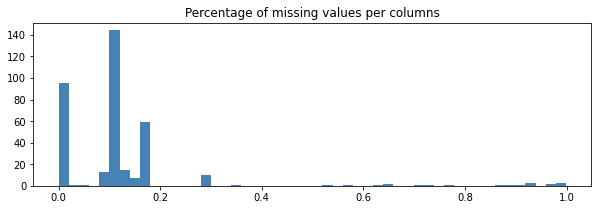

In [27]:
plt.figure(figsize=(10,3))
plt.hist(missing_per_column, bins=50,histtype='stepfilled', color='steelblue')
plt.title('Percentage of missing values per columns')

The plot indicates that there are many columns with more than 30% missing values. I decided to drop these columns.

In [30]:
def drop_missing_cols(df,percent):
    """ Drops columns with more than 30% missing values"""
    missing_values_per_column = df.isnull().mean()
    drop_missing_per_column = missing_values_per_column[missing_values_per_column > percent].index
    df = df.drop(labels=drop_missing_per_column, axis=1, inplace=False)
    return df

In [34]:
azdias_clean_cols = drop_missing_cols(azdias_converted, 0.3)
customers_clean_cols = drop_missing_cols(customers_converted,0.3)

Likewise, I remove the rows with more than 30% missing values

In [35]:
def drop_missing_rows(df,percent):
    """ Drops rows with more than 30% missing values"""
    df = df.dropna(thresh=df.shape[1]*percent, axis='index', inplace = False)
    return df

In [36]:
azdias_clean = drop_missing_rows(azdias_clean_cols, 0.3)

In [37]:
customers_clean = drop_missing_rows(customers_clean_cols, 0.3)

In [38]:
azdias_clean.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [39]:
customers_clean.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9.0,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## 0.5 Standardize features and impute missing values


We will now impute the remaining missing values with the help of the existing data. 
To do this, however, we have to distinguish between different attribute types.


In [40]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817672 entries, 1 to 891220
Columns: 345 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: float64(265), int64(76), object(4)
memory usage: 2.1+ GB


In [41]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145046 entries, 0 to 191651
Columns: 346 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: float64(263), int64(77), object(6)
memory usage: 384.0+ MB


We start with categorical columns. Let's have closer look on their values.

In [42]:
def inspect_object_cols(df):
    """ Prints value counts of columns of type 'object' """
    object_cols = df.select_dtypes(include=['object'])
    for col in object_cols:
        print("\nColumn ",col)
        print(df[col].value_counts())

In [43]:
inspect_object_cols(azdias_clean)


Column  CAMEO_DEU_2015
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             195331
D19_VERSICHERUNGEN         57730
D19_SONSTIGE               44720
D19_VOLLSORTIMENT          34810
D19_SCHUHE                 32576
D19_BUCH_CD                28753
D19_VERSAND_REST           26031
D19_DROGERIEARTIKEL        24071
D19_BANKEN_DIREKT          23271
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20857
D19_

In [44]:
inspect_object_cols(customers_clean)


Column  CAMEO_DEU_2015
2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B     3421
1E     3337
6E     3086
6C     2832
8C     2801
1C     2206
8D     2206
4D     2124
4B     2093
5A     1969
9D     1957
3A     1904
3B     1773
5B     1696
5C     1574
9E     1508
4E     1287
6D     1235
7C     1194
6F     1168
1B     1157
5F     1059
7E     1034
9A     1023
9C      987
9B      917
5E      822
7D      800
6A      762
XX      126
Name: CAMEO_DEU_2015, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             31908
D19_SONSTIGE              14540
D19_VERSICHERUNGEN        10533
D19_BUCH_CD               10038
D19_VOLLSORTIMENT          8647
D19_HAUS_DEKO              8129
D19_SCHUHE                 6316
D19_BEKLEIDUNG_GEH         5975
D19_DROGERIEARTIKEL        5528
D19_ENERGIE                4454
D19_BEKLEIDUNG_REST        4096
D19_VERSAND_RES

EINGEFUEGT_AM holds information on the date and time the entry was added to the database, 
CAMEO_DEU_2015 - contains information about the group a person belongs to according to the CAMEO consumer Segmentation 2015 and
D19_LETZTER_KAUF_BRANCHE - provides information about the last branch in which a purchase was made

While EINGEFUEGT_AM does not add valuable information for our purpose. CAMEO_DEU_2015 and D19_LETZTER_KAUF_BRANCHE have a very high number of levels and would increase the number of features for modeling purposes to a high extent. For this, reason these columns will be dropped. The remaining one (OST_WEST_KZ) will be handled by one-hot encoding and then imputed based on the most frequent value.


In [45]:
azdias_reduced_new = drop_cols(azdias_clean,['EINGEFUEGT_AM','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'])

In [46]:
customers_reduced_new = drop_cols(customers_clean,['EINGEFUEGT_AM','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'])

In [47]:
def encode_ost_west_col(df):
    """
    Function to one-hot-encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].fillna(df["OST_WEST_KZ"].mode().iloc[0])
    
    return df

In [48]:
azdias_clean_obj = encode_ost_west_col(azdias_reduced_new)

In [49]:
customers_clean_obj = encode_ost_west_col(customers_reduced_new)

Let's move on with the columns that contain numerica data. These can be found by again using the info dataset. One way to handle missing data here is to fill them with the median.

In [50]:
numeric_cols = info[info['Meaning'].str.contains("numeric value", na = False)].Attribute.values

In [51]:
def fill_numeric_cols(df, cols):
    
    """
    Function that imputes the missing values of specific columns using the median
    INPUT
    df - the dataframe
    cols - the columns in which one wants to impute the missing values
    OUTPUT
    df - the dataframe with the imputed values
    """
    fill_median = lambda col: col.fillna(col.median())
    df[cols] = df[cols].apply(fill_median, axis = 0)
    return df

In [52]:
azdias_clean_obj_num = fill_numeric_cols(azdias_clean_obj,numeric_cols)

In [53]:
customers_clean_obj_num= fill_numeric_cols(customers_clean_obj,numeric_cols)

Considering the info dataset, it becomes clear that the remaining columns are interval-scaled. We will handle the missing data by imputing them using the mean.

In [54]:
def find_interval_cols(df):
    """
    Function to identify the interval-scaled columns of a dataframe
    """
    interval_cols = list(set(df.select_dtypes(['float64', 'int64']).columns)-set(numeric_cols))
    return interval_cols

In [55]:
def fill_interval_cols(df):
    
    """
    Function that imputes the missing values of interval-scaled columns using the mean
    INPUT
    df - the dataframe
    OUTPUT
    df - the dataframe with the imputed values
    """
    cols = find_interval_cols(df)
    fill_mean = lambda col: round(col.fillna(col.mean()))
    df[cols] = df[cols].apply(fill_mean, axis = 0)
    return df

In [58]:
azdias_clean_all = fill_interval_cols(azdias_clean_obj_num)

In [59]:
customers_clean_all= fill_interval_cols(customers_clean_obj_num)

In [60]:
azdias_clean_all.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817672 entries, 1 to 891220
Data columns (total 342 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   AKT_DAT_KL                   817672 non-null  float64
 1   ALTERSKATEGORIE_FEIN         817672 non-null  float64
 2   ANZ_HAUSHALTE_AKTIV          817672 non-null  float64
 3   ANZ_HH_TITEL                 817672 non-null  float64
 4   ANZ_KINDER                   817672 non-null  float64
 5   ANZ_PERSONEN                 817672 non-null  float64
 6   ANZ_STATISTISCHE_HAUSHALTE   817672 non-null  float64
 7   ANZ_TITEL                    817672 non-null  float64
 8   ARBEIT                       817672 non-null  float64
 9   BALLRAUM                     817672 non-null  float64
 10  CAMEO_DEUG_2015              817672 non-null  float64
 11  CAMEO_INTL_2015              817672 non-null  float64
 12  CJT_GESAMTTYP                817672 non-null  float64
 13

In [61]:
customers_clean_all.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145046 entries, 0 to 191651
Data columns (total 343 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   AKT_DAT_KL                   145046 non-null  float64
 1   ALTERSKATEGORIE_FEIN         145046 non-null  float64
 2   ANZ_HAUSHALTE_AKTIV          145046 non-null  float64
 3   ANZ_HH_TITEL                 145046 non-null  float64
 4   ANZ_KINDER                   145046 non-null  float64
 5   ANZ_PERSONEN                 145046 non-null  float64
 6   ANZ_STATISTISCHE_HAUSHALTE   145046 non-null  float64
 7   ANZ_TITEL                    145046 non-null  float64
 8   ARBEIT                       145046 non-null  float64
 9   BALLRAUM                     145046 non-null  float64
 10  CAMEO_DEUG_2015              145046 non-null  float64
 11  CAMEO_INTL_2015              145046 non-null  float64
 12  CJT_GESAMTTYP                145046 non-null  float64
 13

In [62]:
azdias_clean_all.shape

(817672, 342)

In [63]:
customers_clean_all.shape

(145046, 343)

In [64]:
def remove_corr_cols(df, percent):
    """
    Function that creates a correlation matrix, finds the index of feature columns with correlation
    greater than a given percentage and drops these columns
    
    INPUT
    df - a dataframe
    percent - the threshold correlation percentage
    OUTPUT
    df - the dataframe where highly-correlated columsn are removed
    """
     
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > percent)]

    return df.drop(drop_columns, axis=1)


In [65]:
azdias_without_correlated = remove_corr_cols(azdias_clean_all, 0.90)

In [66]:
customers_without_correlated = remove_corr_cols(customers_clean_all, 0.90)

In [67]:
print(azdias_without_correlated.shape, customers_without_correlated.shape)

(817672, 324) (145046, 328)


## 0.6 Final adjustments

After the data sets have been cleaned, it must be ensured that they contain the same columns. 

In [68]:
def cols_in_df1_notin_df2(df1,df2):
    """
    Function that returns a list of columns that are contained in df1 but not in df2
    """
    extra_cols = [col for col in df1.columns if col not in df2.columns]
    return extra_cols

In [69]:
cols_in_df1_notin_df2(azdias_without_correlated,customers_without_correlated)

['KKK', 'REGIOTYP']

In [70]:
cols_in_df1_notin_df2(customers_without_correlated,azdias_without_correlated)

['D19_VERSAND_DATUM',
 'PLZ8_ANTG1',
 'PLZ8_ANTG3',
 'PRODUCT_GROUP',
 'CUSTOMER_GROUP',
 'ONLINE_PURCHASE']

In [71]:
azdias_final = drop_cols(azdias_without_correlated,cols_in_df1_notin_df2(azdias_without_correlated,customers_without_correlated))

In [72]:
customers_final = drop_cols(customers_without_correlated,cols_in_df1_notin_df2(customers_without_correlated,azdias_without_correlated))

In [73]:
print(azdias_final.shape, customers_final.shape)

(817672, 322) (145046, 322)


In [74]:
azdias_final.to_pickle('azdias_final.pkl')

In [75]:
customers_final.to_pickle('customers_final.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
azdias_final = pd.read_pickle('azdias_final.pkl')
customers_final = pd.read_pickle('customers_final.pkl')

## 1.1 Principal Component Analysis

Since the number of features in the data is relatively high, we can use sklearn's PCA class to apply principal component analysis on the data in order to find the vectors of maximal variance in the data. This  reduces noise and therefore clustering methods are better able to distinguish the different clusters. Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

### 1.1.1 Scaling

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_final),columns =azdias_final.columns)


In [4]:
azdias_scaled

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.258095,1.623062,0.182191,-0.123601,-0.306578,0.235639,-0.060441,-0.164948,0.858130,0.998444,...,1.414254,0.700854,1.068866,1.464844,-0.666306,0.567405,-0.026775,1.140239,0.957351,-1.680056
1,1.258095,0.725093,0.117481,-0.123601,-0.306578,-0.629537,-0.060441,-0.164948,-0.996548,-0.633170,...,-0.345867,1.051492,0.452186,0.019466,-0.666306,0.567405,-1.065170,1.140239,0.957351,0.169789
2,-0.940420,-0.172877,-0.464909,-0.123601,-0.306578,-1.494713,-0.060441,-1.176927,-0.069209,-1.448977,...,-2.105988,0.350216,0.760526,1.826188,-0.078613,0.567405,1.530819,-0.280594,0.957351,1.094712
3,-0.940420,0.051616,-0.335489,-0.123601,-0.306578,1.965992,-0.060441,0.847030,-0.996548,0.182637,...,-0.345867,-1.052336,-0.781174,-0.703223,-1.253998,0.567405,-0.545973,0.429823,-1.044549,0.169789
4,-0.940420,-0.846354,-0.206069,-0.123601,-0.306578,-0.629537,-0.060441,-1.176927,0.858130,0.998444,...,-0.345867,1.402130,-0.164494,-0.703223,1.096773,0.567405,1.530819,0.429823,0.957351,-1.680056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817667,0.158837,0.725093,0.441031,-0.123601,-0.306578,-0.629537,-0.060441,-0.164948,0.858130,0.590540,...,-0.345867,-0.701698,-0.164494,0.742155,-0.666306,-2.032549,-0.545973,0.429823,0.957351,0.169789
817668,1.258095,0.500601,0.182191,-0.123601,-0.306578,-0.629537,-0.060441,0.847030,1.321799,1.406347,...,1.414254,-0.000422,0.452186,0.019466,1.096773,0.567405,0.492423,1.850656,-1.044549,-0.755134
817669,-0.940420,0.725093,-0.335489,-0.123601,-0.306578,-1.494713,-0.060441,-1.176927,0.394460,-0.633170,...,-0.345867,0.350216,0.760526,0.742155,-0.078613,-1.512558,1.530819,0.429823,0.957351,-0.755134
817670,1.258095,1.398570,-0.076649,-0.123601,1.683878,-0.629537,-0.060441,0.847030,-0.996548,1.406347,...,1.414254,1.051492,0.143846,-0.341878,-1.841691,0.567405,0.492423,1.140239,-1.044549,-1.680056


### 1.1.2 Dimensionality Reduction

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

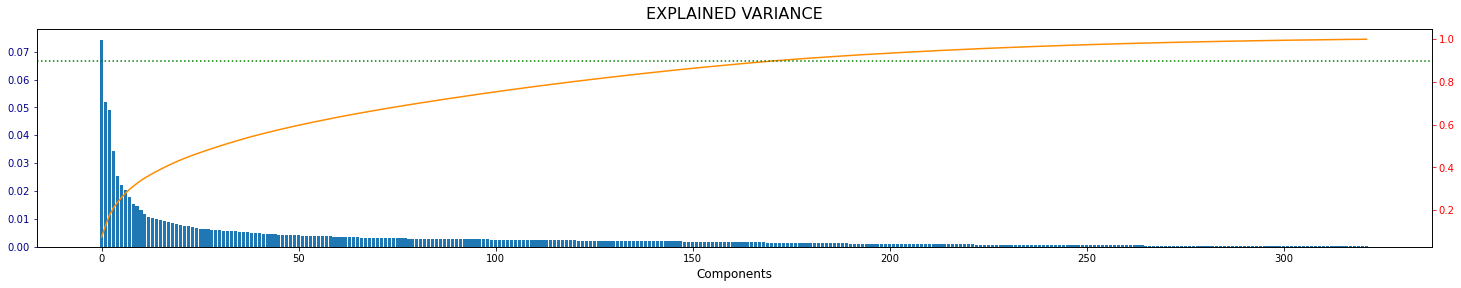

In [6]:
# Investigate the variance accounted for by each principal component.

fig, ax = plt.subplots(figsize=(25, 4))
ax.bar(range(pca.n_components_), pca.explained_variance_ratio_)
ax2 = ax.twinx()
ax2.plot(pca.explained_variance_ratio_.cumsum(), c='darkorange')
ax.tick_params(axis='y', color='darkblue', labelcolor='darkblue')
ax2.tick_params(axis='y', color='red', labelcolor='red')
plt.axhline(y = 0.9, color = 'g', linestyle = ':')
ax.set_title('EXPLAINED VARIANCE', y=1.02, size=16)
ax.set_xlabel('Components', size=12)
plt.show()



The plot clearly shows that already 150 components almost 90% of the variance can be explained. Therefore the number of components is set to 150.

In [7]:
# re-fit with n components
pca = PCA(n_components=150)


azdias_pca = pca.fit_transform(azdias_scaled)


In order to understand what each PCA component represents, we will have a look at the most relevant features (in terms of feature weight) of each component.

In [8]:
def plot_component(comp,n):
    """ Function that plots the n most relevant features of the selected components in terms of feature weight
    INPUT
    comp - component to be considered
    n - top n features
    OUTPUT
    comp_series - Series of the n most relevant features in terms of feature weight
    """
    
    comp_series = pd.Series(data=pca.components_[comp, :], index=azdias_scaled.columns)
    comp_series = comp_series[comp_series.abs().nlargest(n).index]
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.bar(comp_series.index, comp_series)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel("Feature Weight")
    ax.set_title(f'FIRST {n} ORIGINAL VARIABLES RELATED TO THE PRINCIPAL COMPONENT NR. {comp}', y=1.02, size=16)
    plt.show()
    return comp_series

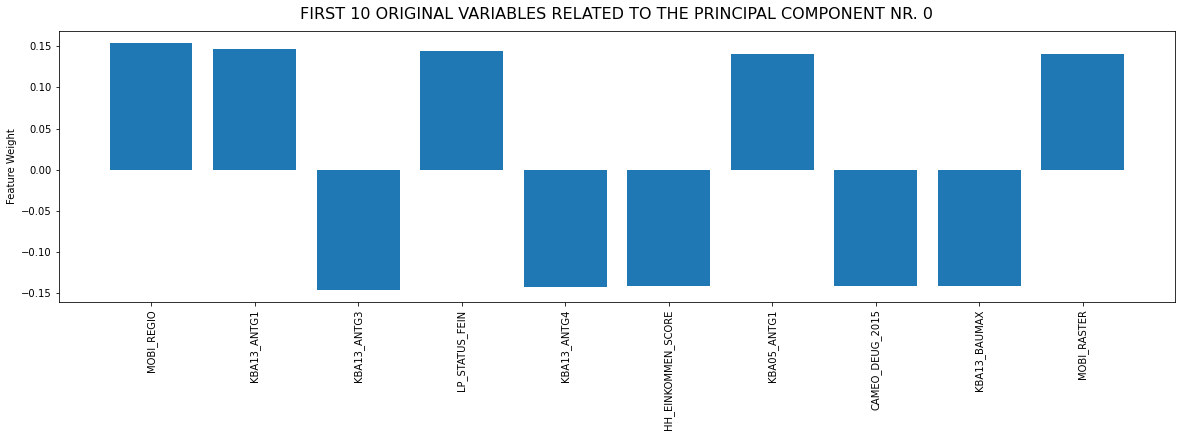

MOBI_REGIO            0.153967
KBA13_ANTG1           0.146801
KBA13_ANTG3          -0.145970
LP_STATUS_FEIN        0.143974
KBA13_ANTG4          -0.141904
HH_EINKOMMEN_SCORE   -0.141446
KBA05_ANTG1           0.141054
CAMEO_DEUG_2015      -0.140815
KBA13_BAUMAX         -0.140658
MOBI_RASTER           0.140123
dtype: float64

In [9]:
plot_component(0,10)

Component 0 has...

**Positive weights** on:  
MOBI_REGIO - moving patterns  
KBA13_ANTG1- number of 1-2 family houses within the PLZ8  
LP_STATUS_FEIN - social status (fine)  

**Negative weights** on:  
KBA13_ANTG3 - number of 6-10 family houses within the PLZ8  
KBA13_ANTG3 - number of > 10 family houses within the PLZ8  
HH_EINKOMMEN_SCORE - estimated household net income    


One can see that all the features deal with the socioeconomic status. Higher positive weights correspond to peple with
low mobility, who live in a region with a high number of 1-2 family houses and who have a high social status, while negative weights mean that people have a lower net income and live in areas with mostly multi-family houses.


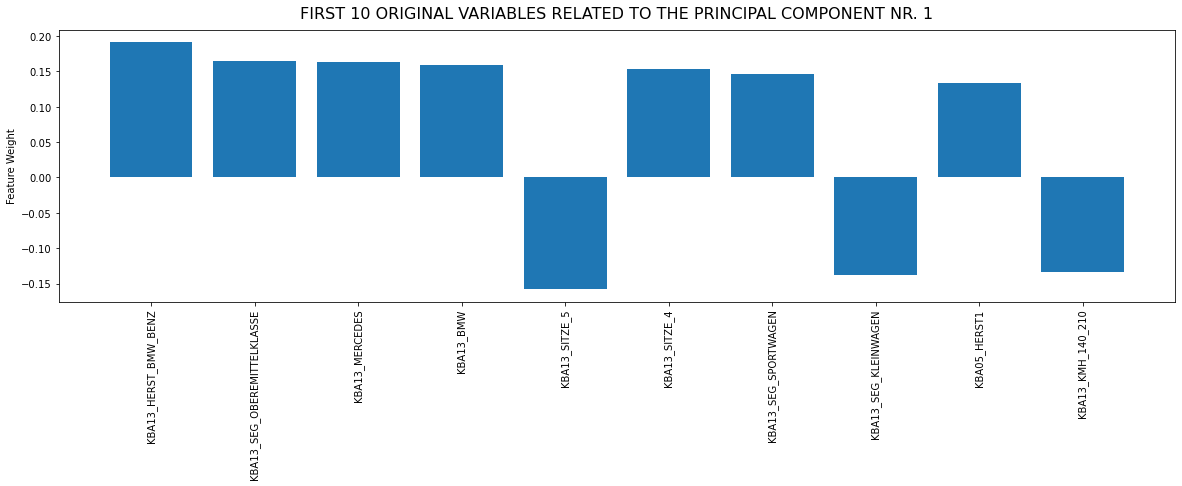

KBA13_HERST_BMW_BENZ           0.191421
KBA13_SEG_OBEREMITTELKLASSE    0.164122
KBA13_MERCEDES                 0.163828
KBA13_BMW                      0.159174
KBA13_SITZE_5                 -0.157970
KBA13_SITZE_4                  0.153443
KBA13_SEG_SPORTWAGEN           0.146454
KBA13_SEG_KLEINWAGEN          -0.137295
KBA05_HERST1                   0.133075
KBA13_KMH_140_210             -0.133073
dtype: float64

In [10]:
plot_component(1,10)

Component 1 has...  

**Positive weights** on:  
KBA13_HERST_BMW_BENZ - share of BMW & Mercedes Benz within the PLZ8  
KBA13_SEG_OBEREMITTELKLASSE - share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)  
KBA13_MERCEDES - share of MERCEDES within the PLZ8  

  
**Negative weights** on:    
KBA13_SITZE_5 - number of cars with 5 seats in the PLZ8  
KBA13_SEG_KLEINWAGEN - share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8  


This component is apparently defined by the number of upper/middle class cars in the region and thus also denotes wealth (albeit only indirectly). Positve weights correpsond to people living in regions with a high share of upper class cars. 

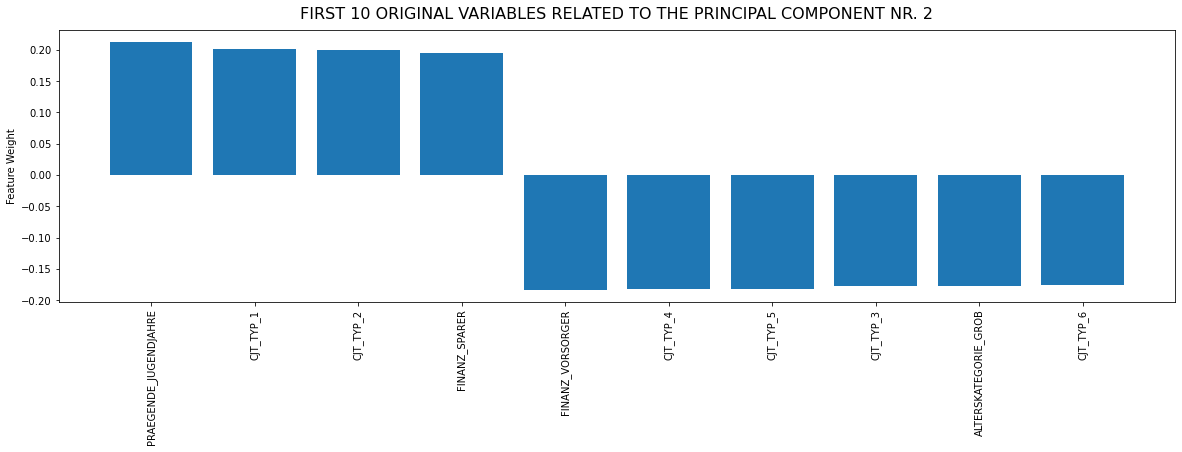

PRAEGENDE_JUGENDJAHRE    0.211552
CJT_TYP_1                0.200797
CJT_TYP_2                0.198861
FINANZ_SPARER            0.194883
FINANZ_VORSORGER        -0.183083
CJT_TYP_4               -0.182788
CJT_TYP_5               -0.181512
CJT_TYP_3               -0.178041
ALTERSKATEGORIE_GROB    -0.177751
CJT_TYP_6               -0.175971
dtype: float64

In [11]:
plot_component(2,10)

Component 2 has:  

**Positive weights** on:  
PRAEGENDE_JUGENDJAHRE - dominating movement in the person's youth (avantgarde or mainstream)  
CJT_TYP_1 - customer journey typology (Advertising- and Consumptionminimalist)  
CJT_TYP_2 - customer journey typology (Advertising- and Consumptiontraditionalist)  
FINANZ_SPARER - financial typology: money saver  

**Negative weights**  on:  
FINANZ_VORSORGER - financial typology: be prepared 
CJT_TYP_4 - customer journey typology (Advertisinginterested Online-shopper)  
CJT_TYP_5 - customer journey typology (Advertising- and Cross-Channel-Enthusiast)      

These features denote financial and consumption attitudes: high positive weights correspond to consumption consumption minimalists, while negative weights corresponte to online shoppers and advertising enthusiasts.

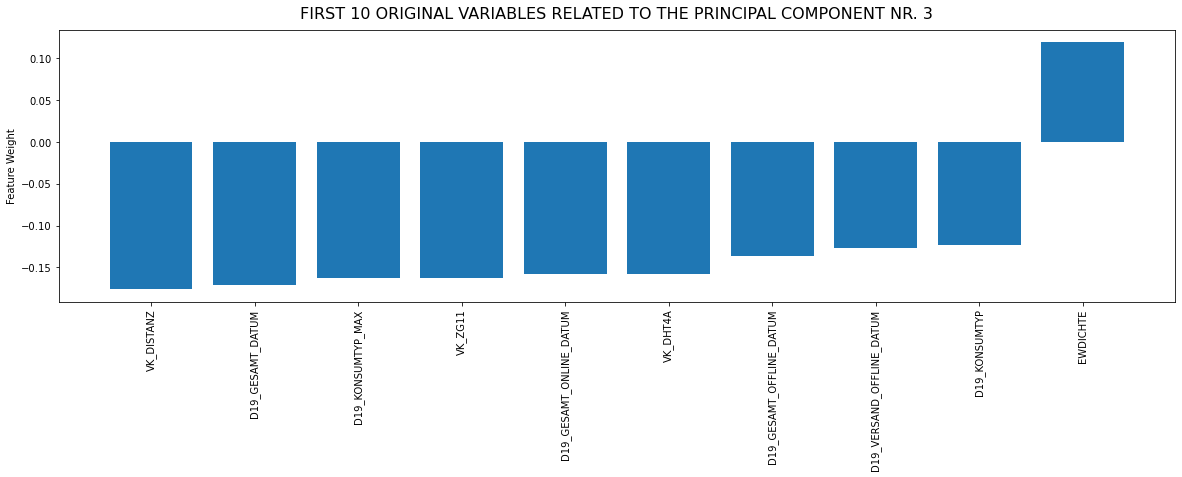

VK_DISTANZ                  -0.176056
D19_GESAMT_DATUM            -0.170494
D19_KONSUMTYP_MAX           -0.162432
VK_ZG11                     -0.162024
D19_GESAMT_ONLINE_DATUM     -0.157730
VK_DHT4A                    -0.157570
D19_GESAMT_OFFLINE_DATUM    -0.135991
D19_VERSAND_OFFLINE_DATUM   -0.126773
D19_KONSUMTYP               -0.123442
EWDICHTE                     0.118872
dtype: float64

In [12]:
plot_component(3,10)

Component 3 has...  

**Postive weights** on:    
EWDICHTE - density of inhabitants per square kilometer    
    
**Negative weights** on:    
VK_DISTANZ - no description provided  
D19_GESAMT_DATUM - actuality of the last transaction with the complete file TOTAL  
D19_KONSUMTYP_MAX - consumption type  
D19_GESAMT_ONLINE_DATUM - actuality of the last transaction with the complete file ONLINE  


Component 3 is less clear, but also seems to denote consumption behaviour. Thus, negatvie weights correspond to rather inactive people without recent online transactions. 

## 1.2 Clustering

After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.


The K-means Clustering algorithm requires us to set the number of the clusters as to minimize the intra-cluster variation.
Choosing the optimal number of clusters is a challenging task since there is no definite way to determine it. One popular approach to solve this is the so-calles 'Elbow method'. Therefore, we iteratively build the K-Means Clustering models as the number of the clusters increases. Then the average distance between all the members of a cluster and the center of each cluster is calculated. The idea is then to choose the number of clusters so that adding another cluster doesn’t improve much better the total within-cluster sum of square. The optimum number can be best viewed in a plotted curve.

In [13]:
from sklearn.cluster import KMeans

In [14]:
# Run k-means clustering for different numbers of clusters
scores = []
for n_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(azdias_pca)
    
    #average within-cluster distances
    scores.append(abs(kmeans.score(azdias_pca)))

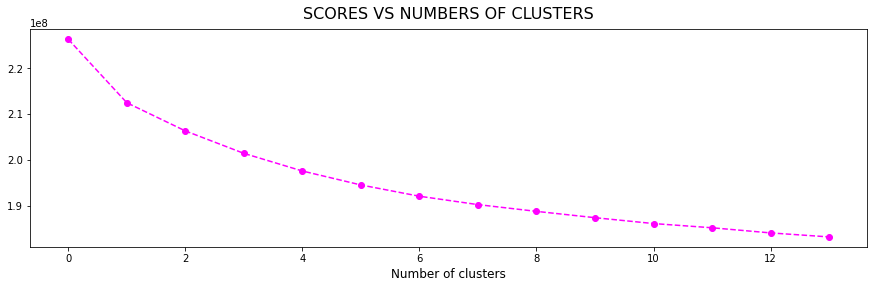

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(scores,  linestyle= "--",marker = "o", color="magenta")
ax.set_xlabel('Number of clusters', size=12)
ax.set_title('SCORES VS NUMBERS OF CLUSTERS', y=1.02, size=16)
plt.show()

From the elbow above, we can see that the sum of sqaured error decreasing with a high slope until around 7 clusters and then the slope decreases.

In [16]:
n_clusters=7
kmeans = KMeans(n_clusters)
kmeans.fit(azdias_pca)
azdias_clusters = kmeans.predict(azdias_pca)

In [17]:
customers_scaled = pd.DataFrame(scaler.transform(customers_final),columns = customers_final.columns)
customers_scaled

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.940420,-0.846354,-0.464909,-0.123601,-0.306578,0.235639,-0.060441,-2.188905,-0.532878,-1.856880,...,0.534194,-0.351060,-1.397854,-1.425912,1.096773,0.567405,1.530819,-0.280594,-1.044549,1.094712
1,1.258095,-0.846354,-0.464909,-0.123601,-0.306578,1.100816,-0.060441,-0.164948,-0.069209,-0.633170,...,-0.345867,-0.000422,-0.472834,-1.064567,-0.078613,0.567405,-0.026775,-0.280594,-1.044549,1.094712
2,-0.940420,-3.091277,-0.464909,-0.123601,-0.306578,-0.629537,-0.060441,-0.164948,1.321799,-0.225266,...,1.414254,1.402130,1.685545,1.826188,1.096773,0.567405,-1.065170,-0.280594,0.957351,1.094712
3,-0.940420,-1.295338,-0.529619,-0.123601,-0.306578,-1.494713,-0.060441,-2.188905,1.321799,-0.633170,...,-0.345867,-0.000422,-1.089514,-1.425912,-0.078613,0.567405,1.530819,-1.701428,-1.044549,1.094712
4,-0.940420,0.051616,-0.076649,-0.123601,-0.306578,1.965992,-0.060441,-0.164948,-0.532878,0.590540,...,1.414254,-1.052336,-0.781174,-0.703223,-1.253998,0.567405,-0.545973,-1.701428,-1.044549,0.169789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145041,-0.940420,-1.070846,-0.464909,-0.123601,-0.306578,-0.629537,-0.060441,-0.164948,-1.460217,-1.856880,...,1.414254,0.700854,0.143846,-0.341878,1.096773,0.567405,-1.584368,-0.280594,-1.044549,0.169789
145042,-0.665606,-3.091277,-0.529619,-0.123601,-0.306578,-1.494713,-0.060441,-2.188905,0.858130,-0.225266,...,-0.345867,1.402130,-0.164494,-0.703223,-0.078613,0.567405,-0.545973,-0.280594,0.957351,1.094712
145043,-0.940420,-0.846354,-0.464909,-0.123601,-0.306578,1.100816,-0.060441,-0.164948,1.321799,-0.633170,...,-1.225927,0.700854,0.143846,-0.341878,-0.666306,0.567405,-0.545973,-0.280594,-1.044549,1.094712
145044,-0.940420,-0.172877,-0.270779,-0.123601,-0.306578,1.965992,-0.060441,-0.164948,-0.532878,-0.633170,...,0.534194,-1.753612,-2.014534,-1.787256,-0.078613,0.567405,-1.065170,-0.280594,0.957351,0.169789


In [83]:
customers_pca = pca.fit_transform(customers_scaled)
kmeans.fit(customers_pca)
customers_clusters = kmeans.predict(customers_pca)

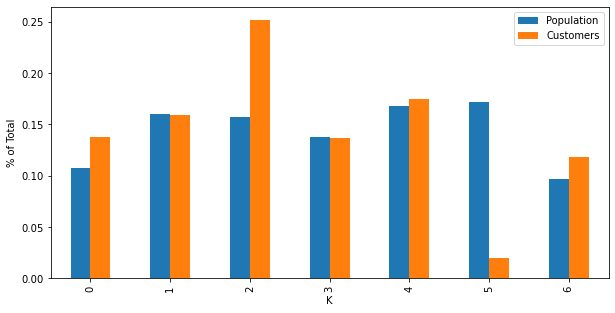

In [84]:
# Compare the proportion of data in each cluster for the customer data with
#  the general population.

pop_proportion = []
cust_proportion = []
x = [i for i in range(n_clusters)]
for i in range(n_clusters):
    pop_proportion.append((azdias_clusters == i).sum()/len(azdias_clusters))
    cust_proportion.append((customers_clusters == i).sum()/len(customers_clusters))
    
df_viz = pd.DataFrame({'K' : x, 'Population' : pop_proportion, 'Customers':cust_proportion})

df_viz.plot(x='K', y = ['Population', 'Customers'], kind='bar', figsize=(10,5))
plt.ylabel('% of Total')
plt.show()

The plot suggests that the clusters 0, 2 and 6 are overrepresented in the customer dataset compared to the general population. In the following, we will analyse what characterises the people in these clusters.

In [85]:
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=azdias_final.columns)
pd.set_option('display.max_columns', None)
cluster_specs.iloc[[0,2,6]]

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0

**Characteristics cluster 0**:

* \> 46 years old
* male
* high income
* golden ager vacation type
* dominating movement in the youth: 60ies - economic miracle
* from West-Germany
* money saver

**Characteristics cluster 2**:

* \> 46 years old
* female
* low income
* A few characteristics that they all have in common is
* dominating movement in the youth: 60ies - economic miracle
* from West-Germany
* money saver

**Characteristics cluster 6**:

* \> 46 years old
* male
* high income
* Golden ager vacation type
* dominating movement in the youth: 60ies - economic miracle
* from West-Germany
* money saver

  
Some characteristics that they all have in common are that they are at least 46 years, the dominating movement in their youth was "60ies - economic miracle", have a money-saving financial standpoind and come from West Germany.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [381]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [382]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [383]:
mailout_train.shape

(42962, 367)

In [384]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [385]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

## 2.1 Preparation

In [386]:
def preprocess_for_superv_model(df):
    """
    Function that uses the functions defined in part 0 to preprocess the dataset
    INPUT
    df - a dataframe
    OUTPUT
    df - the cleaned and scaled dataframe
    """
    print('Format mixed-types \n')
    df = unify_types(df, cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'])
    
    print('Replace unknowns \n') 
    df = convert_unknown(df,info)
    
    print('Remove informative columns and columns with more than 30% missing data')
    df = drop_cols(df,['LNR'])
    #df = drop_missing_cols(df, 0.3)
    #df = drop_missing_rows(df, 0.3)
    
    print('Standardize and impute missing values')
    df= drop_cols(df,['EINGEFUEGT_AM','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'])
    df = encode_ost_west_col(df)
    df = fill_numeric_cols(df,numeric_cols)
    df = fill_interval_cols(df, find_interval_cols(df))
    
    print('Remove highly correlated columns')
    df = remove_corr_cols(df, 0.90)
    
    #print('Delete extra colums')
    #df = drop_cols(df,cols_in_df1_notin_df2(df,azdias_final))
    
    df = pd.DataFrame(scaler.fit_transform(df),columns =df.columns)
    #df= scaler.fit_transform(df)
    return df

In [387]:
mailout_train_scaled = preprocess_for_superv_model(mailout_train)
mailout_test_scaled = preprocess_for_superv_model(mailout_test)



Format mixed-types 

Replace unknowns 



<ipython-input-17-fa8166f909ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_unknown['Value'] = info_unknown['Value'].astype(str)


Remove informative columns and columns with more than 30% missing data
Standardize and impute missing values
Remove highly correlated columns
Format mixed-types 

Replace unknowns 



<ipython-input-17-fa8166f909ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_unknown['Value'] = info_unknown['Value'].astype(str)


Remove informative columns and columns with more than 30% missing data
Standardize and impute missing values
Remove highly correlated columns


In [390]:
print(mailout_train_scaled.shape,mailout_test_scaled.shape)

(42962, 345) (42833, 343)


In [391]:
mailout_train_scaled=drop_cols(mailout_train_scaled,cols_in_df1_notin_df2(mailout_train_scaled,mailout_test_scaled))

In [392]:
mailout_test_scaled=drop_cols(mailout_test_scaled,cols_in_df1_notin_df2(mailout_test_scaled,mailout_train_scaled))

In [393]:
print(mailout_train_scaled.shape,mailout_test_scaled.shape)

(42962, 343) (42833, 343)


In [394]:
mailout_train_scaled.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINI

In [398]:
#mailout_train_Y=pd.DataFrame(mailout_train_scaled['RESPONSE'].values,columns=['RESPONSE'])
mailout_train_Y = mailout_train['RESPONSE']
#mailout_train_X=mailout_train_scaled.drop(['RESPONSE'],axis=1)
mailout_train_X=mailout_train_scaled

## 2.2 Classification

In [401]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline


In [18]:
mailout_train['RESPONSE'].value_counts()

NameError: name 'mailout_train' is not defined

As can seen above, there is a large output class imbalance (there are way more zeros than ones), which makes accuracy a poor metric to be used. Therefore we will resort to the so-calles Area Under the Curve Receiver Operating Characteristics (AUC ROC), which can be interpreted as the probability that the scores given by a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.

In [402]:
def classify(clf, param_grid, X_train=mailout_train_X,y_train=mailout_train_Y):
    """
    Function that fits the selected classifier to the training datasent and prints the resulting ROC AUC score
    
    INPUT:
    - clf: classifier to fit
    - param_grid: classifier parameters used with GridSearchCV
    - X_train: training input 
    - y_train: training response
            
    OUTPUT:
    - grid.best_estimator_: input classifier fitted to the training data
    """
    
    
   
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [403]:
seed = 8

In [404]:
# LogisticRegression
logr = LogisticRegression(random_state=seed,max_iter=500)
classify(lor, {})

0.6601003123050223


LogisticRegression(max_iter=500, random_state=8)

In [405]:
# BaggingClassifier
bagcl = BaggingClassifier(random_state=seed)
classify(bac, {})

0.588618039990187


BaggingClassifier(random_state=8)

In [406]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=seed)
classify(rfc, {})

0.6094602401549027


RandomForestClassifier(random_state=8)

In [407]:
# AdaBoostClassifier
abcl = AdaBoostClassifier(random_state=seed)
abc_best_est = classify(abc, {})

0.7288989347667052


In [408]:
# GradientBoostingClassifier
gbcl = GradientBoostingClassifier(random_state=seed)
classify(gbc, {})

0.7549656704272076


GradientBoostingClassifier(random_state=8)

As can be seen from this comparison, the Gradient Boosting Classifier is the most promising one. We will use it and do some hyperparameter tuning using Grid SearchCV.

In [409]:
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 3],
              'n_estimators':[80],
              'random_state': [seed]
             }

gbc_best_est = classify(gbcl, param_grid)
gbc_best_est

0.765357649449114


GradientBoostingClassifier(max_depth=2, n_estimators=80, random_state=8)

In [372]:
# print the most relevant features of the model
fi = pd.DataFrame({'FI':gbc_best_est.feature_importances_}, index=mailout_train_X.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted

,FI
D19_SOZIALES,0.572581
KOMBIALTER,0.022106
ANZ_TITEL,0.020463
EINGEZOGENAM_HH_JAHR,0.018779
VERDICHTUNGSRAUM,0.017922
...,...
KBA05_SEG9,0.000000
KBA05_VORB1,0.000000
KBA05_VORB2,0.000000
KBA05_ZUL1,0.000000


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [410]:
lnr = mailout_test.LNR

In [411]:
# use the trained model from Part 2 to predict based on test data
response_test = gbc_best_est.predict_proba(mailout_test_scaled)
response_test

array([[0.96373321, 0.03626679],
       [0.96884486, 0.03115514],
       [0.99463562, 0.00536438],
       ...,
       [0.98483232, 0.01516768],
       [0.97341834, 0.02658166],
       [0.97750095, 0.02249905]])

In [412]:
# generate result file
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,0]})
result.to_csv(path_or_buf='./result.csv', index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.963733
1,1770,0.968845
2,1465,0.994636
3,1470,0.995554
4,1478,0.996847
5,1782,0.995346
6,1485,0.995861
7,1519,0.981193
8,1835,0.980005
9,1522,0.995937
